In [21]:
import sys 
from pathlib import Path

#Add the project root to the Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt

from src.features import add_returns, add_mean_reversion_signal, add_momentum_signal, add_vol_regime
from src.data import fetch_yahoo
from src.backtest import backtest_from_signal
from src.metrics import summary

In [22]:
symbol = "SPY"
start, end = "2016-01-01", "2026-01-01"

df = fetch_yahoo(symbol, start, end)
df.head(), df.tail(), df.isna().sum()


(Price             Open        High         Low       Close     Volume
 Ticker             Spy         Spy         Spy         Spy        Spy
 Date                                                                 
 2016-01-04  169.922983  170.380648  168.312652  170.372177  222353500
 2016-01-05  170.694205  171.117974  169.550036  170.660309  110845800
 2016-01-06  168.100756  169.558523  167.473586  168.507584  152112600
 2016-01-07  165.549677  167.337983  164.074955  164.464828  213436100
 2016-01-08  165.431031  165.990409  162.371416  162.659576  209817200,
 Price             Open        High         Low       Close    Volume
 Ticker             Spy         Spy         Spy         Spy       Spy
 Date                                                                
 2025-12-24  687.950012  690.830017  687.799988  690.380005  39445600
 2025-12-26  690.640015  691.659973  689.270020  690.309998  41613300
 2025-12-29  687.539978  689.200012  686.070007  687.849976  62559500
 2025-12-30

MOM:  {'sharpe': -0.8823926544397914, 'max_drawdown': -0.8587607943358564, 'AnnRet(approx)': -0.15867976952711593, 'AvgTurnover': 0.7052505966587113}
MR:  {'sharpe': -0.2222757674376292, 'max_drawdown': -0.5917495491115603, 'AnnRet(approx)': -0.05432773089986831, 'AvgTurnover': 0.1913285600636436}


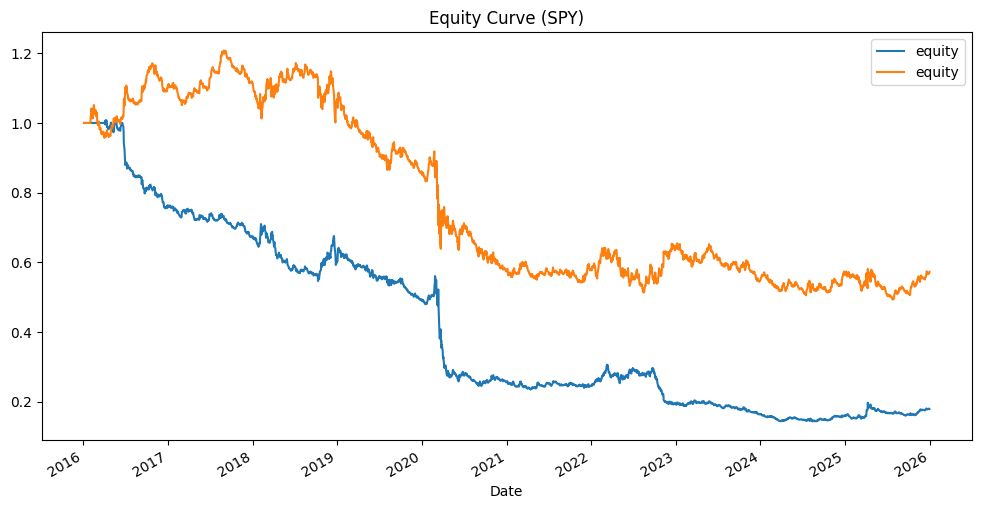

In [25]:
def regime_summary(bt, regime_col="high_vol"):
    out = {}
    for k, sub in bt.dropna(subset=["strat_ret"]).groupby(regime_col):
        out[f"regime={k}"] = summary(sub)
    return out


df = fetch_yahoo("SPY", "2016-01-01", "2026-01-01")
df = add_returns(df)
df = add_momentum_signal(df, lookback=60)
df = add_mean_reversion_signal(df, z_window=20)
df = add_vol_regime(df, vol_window=20, q=0.7)

bt_mom = backtest_from_signal(df, "signal_mom", fee_bps=1.0)
bt_mr = backtest_from_signal(df, "signal_mr", fee_bps=1.0)

'''
print(bt_mom.columns.tolist())
print(bt_mom.head(3))
'''

print("MOM: ", summary(bt_mom))
print("MR: ", summary(bt_mr))

'''
print("MOM regime:", regime_summary(bt_mom))
print("MR  regime:", regime_summary(bt_mr))
'''

plt.figure(figsize=(12, 6))
bt_mom["equity"].plot()
bt_mr["equity"].plot()
plt.legend()
plt.title("Equity Curve (SPY)")
plt.show()
